# 케글 커널 필사 1

* [커널](https://www.kaggle.com/artgor/is-this-malware-eda-fe-and-lgb-updated)
* 투표수 기준으로 정렬

## 사전작업

In [10]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import os
import time
import datetime
import warnings

from tqdm import tqdm_notebook
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import logging

In [11]:
# 모델 관련 라이브러리
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score

In [12]:
# 여러가지 환경 설정
%matplotlib inline
plt.style.use('ggplot')
py.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
logging.basicConfig(filename='./data/log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)

## 데이터 로드

In [19]:
#https://www.kaggle.com/theoviel/load-the-totality-of-the-data
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [20]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [21]:
%%time
train = pd.read_csv('./data/train.csv', dtype=dtypes)

Wall time: 2min 15s


In [23]:
%%time
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])

Wall time: 36.5 s


In [25]:
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
28,PuaMode,2,99.974119,99.974119,category
41,Census_ProcessorClass,3,99.589407,99.589407,category
8,DefaultBrowsersIdentifier,1730,95.141637,95.141637,float16
68,Census_IsFlightingInternal,2,83.044030,83.044030,float16
52,Census_InternalBatteryType,78,71.046809,71.046809,category
71,Census_ThresholdOptIn,2,63.524472,63.524472,float16
75,Census_IsWIMBootEnabled,2,63.439038,63.439038,float16
31,SmartScreen,21,35.610795,48.379658,category
15,OrganizationIdentifier,49,30.841487,47.037662,float16
29,SMode,2,6.027686,93.928812,float16


In [26]:
%%time
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)

Wall time: 13.2 s


In [27]:
train = train[good_cols]

In [29]:
%%time
test_dtypes = {k: v for k, v in dtypes.items() if k in good_cols}
test = pd.read_csv('./data/test.csv', dtype=test_dtypes, usecols=good_cols[:-1])
test.loc[6529507, 'OsBuildLab'] = '17134.1.amd64fre.rs4_release.180410-1804'

Wall time: 1min 29s


## Data Exploration

In [30]:
train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,-85,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,2668.0,9124.0,4.0,5.0,2340.0,476940.0,HDD,299451.0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,2668.0,91656.0,4.0,5.0,2404.0,476940.0,HDD,102385.0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Desktop,4908.0,317701.0,4.0,5.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,ExistsNotSet,Desktop,1443.0,275890.0,4.0,5.0,2272.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,RequireAdmin,Notebook,1443.0,331929.0,4.0,5.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.17134.191,rs4_release,17134,191,Core,CORE,Update,8.0,31,FullAuto,IS_GENUINE,Retail,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1


In [32]:
# function to plot data
def plot_categorical_feature(col, only_bars=False, top_n=10, by_touch=False):
    top_n = top_n if train[col].nunique() > top_n else train[col].nunique()
    print(f"{col} has {train[col].nunique()} unique values and type: {train[col].dtype}.")
    print(train[col].value_counts(normalize=True, dropna=False).head())
    if not by_touch:
        if not only_bars:
            df = train.groupby([col]).agg({'HasDetections': ['count', 'mean']})
            df = df.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
            data = [go.Bar(x=df.index, y=df['HasDetections']['count'].values, name='counts'),
                    go.Scatter(x=df.index, y=df['HasDetections']['mean'], name='Detections rate', yaxis='y2')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories and mean target value",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis2=dict(title='Detections rate', overlaying='y', side='right')),
                           legend=dict(orientation="v"))

        else:
            top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
            df0 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 1), col].value_counts().head(10).sort_index()
            df1 = train.loc[(train[col].isin(top_cat)) & (train['HasDetections'] == 0), col].value_counts().head(10).sort_index()
            data = [go.Bar(x=df0.index, y=df0.values, name='Has Detections'),
                    go.Bar(x=df1.index, y=df1.values, name='No Detections')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                ),
                           legend=dict(orientation="v"), barmode='group')
        
        py.iplot(dict(data=data, layout=layout))
        
    else:
        top_n = 10
        top_cat = list(train[col].value_counts(dropna=False).index[:top_n])
        df = train.loc[train[col].isin(top_cat)]

        df1 = train.loc[train['Census_IsTouchEnabled'] == 1]
        df0 = train.loc[train['Census_IsTouchEnabled'] == 0]

        df0_ = df0.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df0_ = df0_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        df1_ = df1.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df1_ = df1_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        data1 = [go.Bar(x=df0_.index, y=df0_['HasDetections']['count'].values, name='Nontouch device counts'),
                go.Scatter(x=df0_.index, y=df0_['HasDetections']['mean'], name='Detections rate for nontouch devices', yaxis='y2')]
        data2 = [go.Bar(x=df1_.index, y=df1_['HasDetections']['count'].values, name='Touch device counts'),
                go.Scatter(x=df1_.index, y=df1_['HasDetections']['mean'], name='Detections rate for touch devices', yaxis='y2')]

        layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories for nontouch devices",
                            xaxis = dict(title = f'{col}',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,
                                         type='category'),
                            yaxis = dict(title = 'Counts',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,),
                                    yaxis2=dict(title='Detections rate', overlaying='y', side='right'),
                            ),
                       legend=dict(orientation="v"), barmode='group')

        py.iplot(dict(data=data1, layout=layout))
        layout['title'] = f"Counts of {col} by top-{top_n} categories for touch devices"
        py.iplot(dict(data=data2, layout=layout))

### Target

In [31]:
train['HasDetections'].value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

### Census_IsTouchEnabled

In [33]:
plot_categorical_feature('Census_IsTouchEnabled', True)

Census_IsTouchEnabled has 2 unique values and type: int8.
0    0.874457
1    0.125543
Name: Census_IsTouchEnabled, dtype: float64


### EngineVersion

In [36]:
plot_categorical_feature('EngineVersion')

EngineVersion has 70 unique values and type: category.
1.1.15200.1    0.430990
1.1.15100.1    0.412030
1.1.15000.2    0.029728
1.1.14901.4    0.023809
1.1.14600.4    0.018000
Name: EngineVersion, dtype: float64


### AppVersion

In [35]:
plot_categorical_feature('AppVersion')


AppVersion has 110 unique values and type: category.
4.18.1807.18075    0.576050
4.18.1806.18062    0.095380
4.12.16299.15      0.040338
4.10.209.0         0.030539
4.13.17134.1       0.028837
Name: AppVersion, dtype: float64


### AvSigVersion

In [37]:
plot_categorical_feature('AvSigVersion')

AvSigVersion has 8531 unique values and type: category.
1.273.1420.0    0.011469
1.263.48.0      0.010987
1.275.1140.0    0.010899
1.275.727.0     0.010362
1.273.371.0     0.009748
Name: AvSigVersion, dtype: float64


### AVProductStatesIdentifier

In [39]:
plot_categorical_feature('AVProductStatesIdentifier', True, 10)

AVProductStatesIdentifier has 28970 unique values and type: float32.
53447.0    0.652870
7945.0     0.053343
47238.0    0.036727
62773.0    0.029901
46413.0    0.012652
Name: AVProductStatesIdentifier, dtype: float64


In [40]:
train['AVProductStatesIdentifier'] = train['AVProductStatesIdentifier'].astype('category')
test['AVProductStatesIdentifier'] = test['AVProductStatesIdentifier'].astype('category')

### AVProductsInstalled

In [42]:
plot_categorical_feature('AVProductsInstalled', True)

AVProductsInstalled has 8 unique values and type: float16.
 1.0    0.695949
 2.0    0.275628
 3.0    0.023326
NaN     0.004060
 4.0    0.000982
Name: AVProductsInstalled, dtype: float64


In [43]:
train['AVProductsInstalled'] = train['AVProductsInstalled'].astype('category')
test['AVProductsInstalled'] = test['AVProductsInstalled'].astype('category')

In [46]:
plot_categorical_feature('AVProductsInstalled', True, by_touch=True)

AVProductsInstalled has 8 unique values and type: category.
 1.0    0.695949
 2.0    0.275628
 3.0    0.023326
NaN     0.004060
 4.0    0.000982
Name: AVProductsInstalled, dtype: float64


### CountryIdentifier

In [47]:
plot_categorical_feature('CountryIdentifier', True, 20)


CountryIdentifier has 222 unique values and type: int16.
43     0.044519
29     0.039006
141    0.037372
93     0.031791
171    0.031449
Name: CountryIdentifier, dtype: float64


In [48]:
train['CountryIdentifier'] = train['CountryIdentifier'].astype('category')
test['CountryIdentifier'] = test['CountryIdentifier'].astype('category')

### CityIdentifier

In [49]:
plot_categorical_feature('CityIdentifier', True, 20)


CityIdentifier has 107366 unique values and type: float32.
NaN          0.036475
 130775.0    0.010627
 16668.0     0.009503
 82373.0     0.009338
 10222.0     0.008050
Name: CityIdentifier, dtype: float64


In [51]:
train['CityIdentifier'] = train['CityIdentifier'].astype('category')
test['CityIdentifier'] = test['CityIdentifier'].astype('category')

### OrganizationIdentifier

In [52]:
plot_categorical_feature('OrganizationIdentifier', True)


OrganizationIdentifier has 49 unique values and type: float16.
 27.0    0.470377
NaN      0.308415
 18.0    0.197745
 48.0    0.007156
 50.0    0.005100
Name: OrganizationIdentifier, dtype: float64


In [53]:
train['OrganizationIdentifier'] = train['OrganizationIdentifier'].astype('category')
test['OrganizationIdentifier'] = test['OrganizationIdentifier'].astype('category')

In [54]:
plot_categorical_feature('OrganizationIdentifier', True, by_touch=True)


OrganizationIdentifier has 49 unique values and type: category.
 27.0    0.470377
NaN      0.308415
 18.0    0.197745
 48.0    0.007156
 50.0    0.005100
Name: OrganizationIdentifier, dtype: float64


### GeoNameIdentifier

In [55]:
plot_categorical_feature('GeoNameIdentifier', True)

GeoNameIdentifier has 292 unique values and type: float16.
277.0    0.171712
211.0    0.047432
53.0     0.045823
89.0     0.040441
240.0    0.038846
Name: GeoNameIdentifier, dtype: float64


In [56]:
train['GeoNameIdentifier'] = train['GeoNameIdentifier'].astype('category')
test['GeoNameIdentifier'] = test['GeoNameIdentifier'].astype('category')

### LocaleEnglishNameIdentifier

In [57]:
plot_categorical_feature('LocaleEnglishNameIdentifier', True)


LocaleEnglishNameIdentifier has 252 unique values and type: int8.
 75    0.234780
-74    0.050450
 74    0.046075
 42    0.045913
 88    0.042058
Name: LocaleEnglishNameIdentifier, dtype: float64


In [58]:
train['LocaleEnglishNameIdentifier'] = train['LocaleEnglishNameIdentifier'].astype('category')
test['LocaleEnglishNameIdentifier'] = test['LocaleEnglishNameIdentifier'].astype('category')

### OsPlatformSubRelease

In [59]:
plot_categorical_feature('OsPlatformSubRelease', True, by_touch=True)


OsPlatformSubRelease has 9 unique values and type: category.
rs4    0.438887
rs3    0.280635
rs2    0.087460
rs1    0.081917
th2    0.046136
Name: OsPlatformSubRelease, dtype: float64


### OsBuildLab


In [60]:
plot_categorical_feature('OsBuildLab', True)


OsBuildLab has 663 unique values and type: category.
17134.1.amd64fre.rs4_release.180410-1804                 0.410044
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908    0.140411
16299.15.amd64fre.rs3_release.170928-1534                0.107724
15063.0.amd64fre.rs2_release.170317-1834                 0.080484
17134.1.x86fre.rs4_release.180410-1804                   0.028815
Name: OsBuildLab, dtype: float64


### IeVerIdentifier

In [61]:
plot_categorical_feature('IeVerIdentifier', True)


IeVerIdentifier has 303 unique values and type: float16.
137.0    0.435560
117.0    0.198166
108.0    0.053174
111.0    0.052438
98.0     0.039726
Name: IeVerIdentifier, dtype: float64


In [62]:
train['IeVerIdentifier'] = train['IeVerIdentifier'].astype('category')
test['IeVerIdentifier'] = test['IeVerIdentifier'].astype('category')

### Census_OEMNameIdentifier

In [63]:
plot_categorical_feature('Census_OEMNameIdentifier', True)


Census_OEMNameIdentifier has 2564 unique values and type: float16.
2668.0    0.144289
2102.0    0.116412
1443.0    0.106432
2206.0    0.103609
585.0     0.100370
Name: Census_OEMNameIdentifier, dtype: float64


In [64]:
train['Census_OEMNameIdentifier'] = train['Census_OEMNameIdentifier'].astype('category')
test['Census_OEMNameIdentifier'] = test['Census_OEMNameIdentifier'].astype('category')

### Census_OEMModelIdentifier

In [65]:
plot_categorical_feature('Census_OEMModelIdentifier', True)


Census_OEMModelIdentifier has 175365 unique values and type: float32.
 313586.0    0.034163
 242491.0    0.029522
 317701.0    0.015584
 317708.0    0.012919
NaN          0.011459
Name: Census_OEMModelIdentifier, dtype: float64


In [66]:
train['Census_OEMModelIdentifier'] = train['Census_OEMModelIdentifier'].astype('category')
test['Census_OEMModelIdentifier'] = test['Census_OEMModelIdentifier'].astype('category')

In [67]:
train['Census_ProcessorModelIdentifier'] = train['Census_ProcessorModelIdentifier'].astype('category')
test['Census_ProcessorModelIdentifier'] = test['Census_ProcessorModelIdentifier'].astype('category')

In [68]:
train['Census_InternalBatteryNumberOfCharges'] = train['Census_InternalBatteryNumberOfCharges'].astype('category')
test['Census_InternalBatteryNumberOfCharges'] = test['Census_InternalBatteryNumberOfCharges'].astype('category')

In [69]:
train['Census_OSBuildNumber'] = train['Census_OSBuildNumber'].astype('category')
test['Census_OSBuildNumber'] = test['Census_OSBuildNumber'].astype('category')

In [70]:
train['Census_OSBuildRevision'] = train['Census_OSBuildRevision'].astype('category')
test['Census_OSBuildRevision'] = test['Census_OSBuildRevision'].astype('category')

In [71]:
train['Census_FirmwareManufacturerIdentifier'] = train['Census_FirmwareManufacturerIdentifier'].astype('category')
test['Census_FirmwareManufacturerIdentifier'] = test['Census_FirmwareManufacturerIdentifier'].astype('category')

In [72]:
train['Census_FirmwareVersionIdentifier'] = train['Census_FirmwareVersionIdentifier'].astype('category')
test['Census_FirmwareVersionIdentifier'] = test['Census_FirmwareVersionIdentifier'].astype('category')

In [73]:
train['OsBuild'] = train['OsBuild'].astype('category')
test['OsBuild'] = test['OsBuild'].astype('category')

In [74]:
def group_battery(x):
    x = x.lower()
    if 'li' in x:
        return 1
    else:
        return 0
    
train['Census_InternalBatteryType'] = train['Census_InternalBatteryType'].apply(group_battery)
test['Census_InternalBatteryType'] = test['Census_InternalBatteryType'].apply(group_battery)

In [75]:
def rename_edition(x):
    x = x.lower()
    if 'core' in x:
        return 'Core'
    elif 'pro' in x:
        return 'pro'
    elif 'enterprise' in x:
        return 'Enterprise'
    elif 'server' in x:
        return 'Server'
    elif 'home' in x:
        return 'Home'
    elif 'education' in x:
        return 'Education'
    elif 'cloud' in x:
        return 'Cloud'
    else:
        return x

In [76]:
train['Census_OSEdition'] = train['Census_OSEdition'].astype(str)
test['Census_OSEdition'] = test['Census_OSEdition'].astype(str)
train['Census_OSEdition'] = train['Census_OSEdition'].apply(rename_edition)
test['Census_OSEdition'] = test['Census_OSEdition'].apply(rename_edition)
train['Census_OSEdition'] = train['Census_OSEdition'].astype('category')
test['Census_OSEdition'] = test['Census_OSEdition'].astype('category')

In [77]:
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype(str)
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype(str)
train['Census_OSSkuName'] = train['Census_OSSkuName'].apply(rename_edition)
test['Census_OSSkuName'] = test['Census_OSSkuName'].apply(rename_edition)
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype('category')
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype('category')

In [78]:
train['Census_OSInstallLanguageIdentifier'] = train['Census_OSInstallLanguageIdentifier'].astype('category')
test['Census_OSInstallLanguageIdentifier'] = test['Census_OSInstallLanguageIdentifier'].astype('category')

In [79]:
train['Census_OSUILocaleIdentifier'] = train['Census_OSUILocaleIdentifier'].astype('category')
test['Census_OSUILocaleIdentifier'] = test['Census_OSUILocaleIdentifier'].astype('category')

In [80]:
train['OsSuite'] = train['OsSuite'].astype('category')
test['OsSuite'] = test['OsSuite'].astype('category')

In [81]:
train['Wdft_RegionIdentifier'] = train['Wdft_RegionIdentifier'].astype('category')
test['Wdft_RegionIdentifier'] = test['Wdft_RegionIdentifier'].astype('category')

## Feature engineering and transformation


In [82]:
train['OsBuildLab'] = train['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
train['OsBuildLab'] = train['OsBuildLab'].fillna('0.0.0.0.0-0')
test['OsBuildLab'] = test['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
test['OsBuildLab'] = test['OsBuildLab'].fillna('0.0.0.0.0-0')

In [83]:
def fe(df):
    df['EngineVersion_2'] = df['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['EngineVersion_3'] = df['EngineVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    df['AppVersion_1'] = df['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['AppVersion_2'] = df['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['AppVersion_3'] = df['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    df['AvSigVersion_0'] = df['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    df['AvSigVersion_1'] = df['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['AvSigVersion_2'] = df['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')

    df['OsBuildLab_0'] = df['OsBuildLab'].apply(lambda x: x.split('.')[0]).astype('category')
    df['OsBuildLab_1'] = df['OsBuildLab'].apply(lambda x: x.split('.')[1]).astype('category')
    df['OsBuildLab_2'] = df['OsBuildLab'].apply(lambda x: x.split('.')[2]).astype('category')
    df['OsBuildLab_3'] = df['OsBuildLab'].apply(lambda x: x.split('.')[3]).astype('category')
    # df['OsBuildLab_40'] = df['OsBuildLab'].apply(lambda x: x.split('.')[4].split('-')[0]).astype('category')
    # df['OsBuildLab_41'] = df['OsBuildLab'].apply(lambda x: x.split('.')[4].split('-')[1]).astype('category')

    df['Census_OSVersion_0'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    df['Census_OSVersion_1'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['Census_OSVersion_2'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['Census_OSVersion_3'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    # https://www.kaggle.com/adityaecdrid/simple-feature-engineering-xd
    df['primary_drive_c_ratio'] = df['Census_SystemVolumeTotalCapacity']/ df['Census_PrimaryDiskTotalCapacity']
    df['non_primary_drive_MB'] = df['Census_PrimaryDiskTotalCapacity'] - df['Census_SystemVolumeTotalCapacity']

    df['aspect_ratio'] = df['Census_InternalPrimaryDisplayResolutionHorizontal']/ df['Census_InternalPrimaryDisplayResolutionVertical']

    df['monitor_dims'] = df['Census_InternalPrimaryDisplayResolutionHorizontal'].astype(str) + '*' + df['Census_InternalPrimaryDisplayResolutionVertical'].astype('str')
    df['monitor_dims'] = df['monitor_dims'].astype('category')

    df['dpi'] = ((df['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + df['Census_InternalPrimaryDisplayResolutionVertical']**2)**.5)/(df['Census_InternalPrimaryDiagonalDisplaySizeInInches'])

    df['dpi_square'] = df['dpi'] ** 2

    df['MegaPixels'] = (df['Census_InternalPrimaryDisplayResolutionHorizontal'] * df['Census_InternalPrimaryDisplayResolutionVertical'])/1e6

    df['Screen_Area'] = (df['aspect_ratio']* (df['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(df['aspect_ratio']**2 + 1)

    df['ram_per_processor'] = df['Census_TotalPhysicalRAM']/ df['Census_ProcessorCoreCount']

    df['new_num_0'] = df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] / df['Census_ProcessorCoreCount']

    df['new_num_1'] = df['Census_ProcessorCoreCount'] * df['Census_InternalPrimaryDiagonalDisplaySizeInInches']
    
    df['Census_IsFlightingInternal'] = df['Census_IsFlightingInternal'].fillna(1)
    df['Census_ThresholdOptIn'] = df['Census_ThresholdOptIn'].fillna(1)
    df['Census_IsWIMBootEnabled'] = df['Census_IsWIMBootEnabled'].fillna(1)
    df['Wdft_IsGamer'] = df['Wdft_IsGamer'].fillna(0)
    
    return df

In [84]:
%%time
train = fe(train)
test = fe(test)

Wall time: 31.6 s


In [85]:
cat_cols = [col for col in train.columns if col not in ['MachineIdentifier', 'Census_SystemVolumeTotalCapacity', 'HasDetections'] and str(train[col].dtype) == 'category']
len(cat_cols)

57

In [87]:
more_cat_cols = []
add_cat_feats = [
 'Census_OSBuildRevision',
 'OsBuildLab',
 'SmartScreen',
'AVProductsInstalled']
for col1 in add_cat_feats:
    for col2 in add_cat_feats:
        if col1 != col2:
            train[col1 + '__' + col2] = train[col1].astype(str) + train[col2].astype(str)
            train[col1 + '__' + col2] = train[col1 + '__' + col2].astype('category')
            
            test[col1 + '__' + col2] = test[col1].astype(str) + test[col2].astype(str)
            test[col1 + '__' + col2] = test[col1 + '__' + col2].astype('category')
            more_cat_cols.append(col1 + '__' + col2)
            
cat_cols = cat_cols + more_cat_cols

In [88]:
to_encode = []
for col in cat_cols:
    if train[col].nunique() > 1000:
        print(col, train[col].nunique())
        to_encode.append(col)

AvSigVersion 8531
AVProductStatesIdentifier 28970
CityIdentifier 107366
Census_OEMNameIdentifier 2564
Census_OEMModelIdentifier 175365
Census_ProcessorModelIdentifier 2583
Census_InternalBatteryNumberOfCharges 41087
Census_FirmwareVersionIdentifier 50494
AvSigVersion_2 2766
monitor_dims 10061
Census_OSBuildRevision__OsBuildLab 15367
Census_OSBuildRevision__SmartScreen 1763
Census_OSBuildRevision__AVProductsInstalled 1169
OsBuildLab__Census_OSBuildRevision 15367
OsBuildLab__SmartScreen 2307
OsBuildLab__AVProductsInstalled 1951
SmartScreen__Census_OSBuildRevision 1763
SmartScreen__OsBuildLab 2307
AVProductsInstalled__Census_OSBuildRevision 1169
AVProductsInstalled__OsBuildLab 1951


### Frequency encoding

In [89]:
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [90]:
for col in tqdm_notebook(to_encode):
    freq_enc_dict = frequency_encoding(col)
    train[col] = train[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[col] = test[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    cat_cols.remove(col)

### Label encoding

In [92]:
%%time
indexer = {}
for col in cat_cols:
    # print(col)
    _, indexer[col] = pd.factorize(train[col].astype(str), sort=True)
    
for col in tqdm_notebook(cat_cols):
    # print(col)
    train[col] = indexer[col].get_indexer(train[col].astype(str))
    test[col] = indexer[col].get_indexer(test[col].astype(str))


Wall time: 4min 7s


In [105]:
del indexer

In [106]:
train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,EngineVersion_2,EngineVersion_3,AppVersion_1,AppVersion_2,AppVersion_3,AvSigVersion_0,AvSigVersion_1,AvSigVersion_2,OsBuildLab_0,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,Census_OSVersion_0,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,primary_drive_c_ratio,non_primary_drive_MB,aspect_ratio,monitor_dims,dpi,dpi_square,MegaPixels,Screen_Area,ram_per_processor,new_num_0,new_num_1,Census_OSBuildRevision__OsBuildLab,Census_OSBuildRevision__SmartScreen,Census_OSBuildRevision__AVProductsInstalled,OsBuildLab__Census_OSBuildRevision,OsBuildLab__SmartScreen,OsBuildLab__AVProductsInstalled,SmartScreen__Census_OSBuildRevision,SmartScreen__OsBuildLab,SmartScreen__AVProductsInstalled,AVProductsInstalled__Census_OSBuildRevision,AVProductsInstalled__OsBuildLab,AVProductsInstalled__SmartScreen
0,0000028988387b115f69f31a3bf04f09,65,59,134.0,0.0,1,144,205.0,8,223,111,6,3,4,273,6,24,15,2,0.0,22022.0,4.0,5.0,135.0,476940.0,0,299451.0,4096.0,24,18.906250,1440.0,900.0,1,0,1.0,361,10,96,75,6,5,6,18,17,5,1,2,1.0,1.0,448,2572.0,0,1.0,0,0.0,1,0,59,1,8,25,54,1,48,211.0,19,1,1,14,0,0,96,75,0.627859,177489.0,1.599609,6.0,inf,inf,inf,160.7500,1024.0,4.726562,75.62500,3.0,8.0,3.0,3.0,0.0,0.0,8.0,0.0,61,3.0,0.0,16
1,000007535c3f730efa9ea0b7ef1bd645,55,26,0.0,0.0,1,215,171.0,8,22,213,6,3,4,273,6,24,15,8,0.0,118655.0,4.0,5.0,134.0,476940.0,0,102385.0,4096.0,38,13.898438,1366.0,768.0,3,0,2.0,357,10,96,1,6,5,2,37,79,5,2,2,1.0,1.0,448,1415.0,0,1.0,0,0.0,13,0,54,4,3,6,1,1,43,0.0,19,1,1,14,0,0,96,1,0.214671,374555.0,1.778320,0.0,inf,inf,inf,82.5000,1024.0,3.474609,55.59375,19.0,17.0,19.0,19.0,0.0,0.0,17.0,0.0,61,19.0,0.0,16
2,000007905a28d863f6d0d597892cd692,65,59,336.0,0.0,1,207,673.0,8,254,197,6,12,4,273,4,24,13,2,10.0,2.0,4.0,5.0,191.0,114473.0,1,113907.0,4096.0,24,21.500000,1920.0,1080.0,1,0,1.0,361,10,96,75,1,1,6,36,78,2,1,1,1.0,1.0,89,184.0,0,1.0,0,0.0,8,0,59,1,8,25,54,1,48,295.0,19,1,1,14,0,0,96,75,0.995056,566.0,1.777344,1.0,inf,inf,inf,197.6250,1024.0,5.375000,86.00000,3.0,7.0,3.0,3.0,1.0,0.0,7.0,1.0,47,3.0,0.0,14
3,00000b11598a75ea8ba1beea8459149f,65,59,25.0,0.0,1,209,20.0,49,20,145,6,3,4,273,6,24,7,2,2.0,158.0,4.0,5.0,63.0,238475.0,2,227116.0,4096.0,36,18.500000,1366.0,768.0,1,0,1.0,365,10,96,161,6,5,6,8,112,2,1,1,1.0,1.0,240,30.0,0,1.0,0,0.0,8,1,59,1,8,25,54,1,48,23.0,19,1,1,14,0,0,96,161,0.952368,11359.0,1.778320,0.0,inf,inf,inf,146.1250,1024.0,4.625000,74.00000,0.0,22.0,0.0,0.0,6.0,0.0,22.0,6.0,19,0.0,0.0,8
4,000014a5f00daa18e76b81417eeb99fc,65,59,18.0,0.0,1,89,13.0,49,195,225,6,12,4,273,4,24,13,8,2.0,2269.0,4.0,5.0,52.0,476940.0,0,101900.0,6144.0,41,14.000000,1366.0,768.0,3,1,0.0,363,10,96,136,1,1,7,37,

## Idea of training on all data

In [107]:
y = train['HasDetections']
train = train.drop(['HasDetections', 'MachineIdentifier'], axis=1)
test = test.drop(['MachineIdentifier'], axis=1)
gc.collect()
train.sort_values('AvSigVersion')
train1 = train[:4000000]
train = train[4000000:8000000]

y1 = y[:4000000]
y = y[4000000:8000000]

In [108]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)
# folds = TimeSeriesSplit(n_splits=5)

In [111]:
from numba import jit
# fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

# idea from this kernel: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    #predictions += current_pred / min(folds.n_splits, max_iter)
    return current_pred


def train_model(X=train, X_test=test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature = cat_cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature = cat_cols)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200,
                    feval=eval_auc)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            # print('predicting on test')
            # y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = predict_chunk(model, X_test)
            # print('predicted')
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            #y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            y_pred = predict_chunk(model, xgb.DMatrix(X_test))
            
        if model_type == 'lcv':
            model = LogisticRegressionCV(scoring='roc_auc', cv=3)
            model.fit(X_train, y_train)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
        
        if make_oof:
            oof[valid_index] = y_pred_valid.reshape(-1,)
            
        scores.append(fast_auc(y_valid, y_pred_valid))
        print('Fold roc_auc:', roc_auc_score(y_valid, y_pred_valid))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            logging.info('Top features')
            for f in best_features.sort_values(by="importance", ascending=False)['feature'].values:
                logging.info(f)

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

In [112]:
params = {'num_leaves': 256,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "lambda_l1": 0.15,
         "lambda_l2": 0.15,
         "random_state": 42,          
         "verbosity": -1}

Fold 1 started at Sat Feb  9 21:53:33 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.565337	training's auc: 0.780653	valid_1's binary_logloss: 0.603249	valid_1's auc: 0.73028
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.566296	training's auc: 0.77947	valid_1's binary_logloss: 0.603243	valid_1's auc: 0.730292
Fold roc_auc: 0.7302919851165133

Fold 2 started at Sat Feb  9 22:19:24 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.565558	training's auc: 0.780453	valid_1's binary_logloss: 0.602246	valid_1's auc: 0.731414
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.568057	training's auc: 0.777368	valid_1's binary_logloss: 0.602188	valid_1's auc: 0.731505
Fold roc_auc: 0.7315044700282973

Fold 3 started at Sat Feb  9 22:42:59 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.565408	

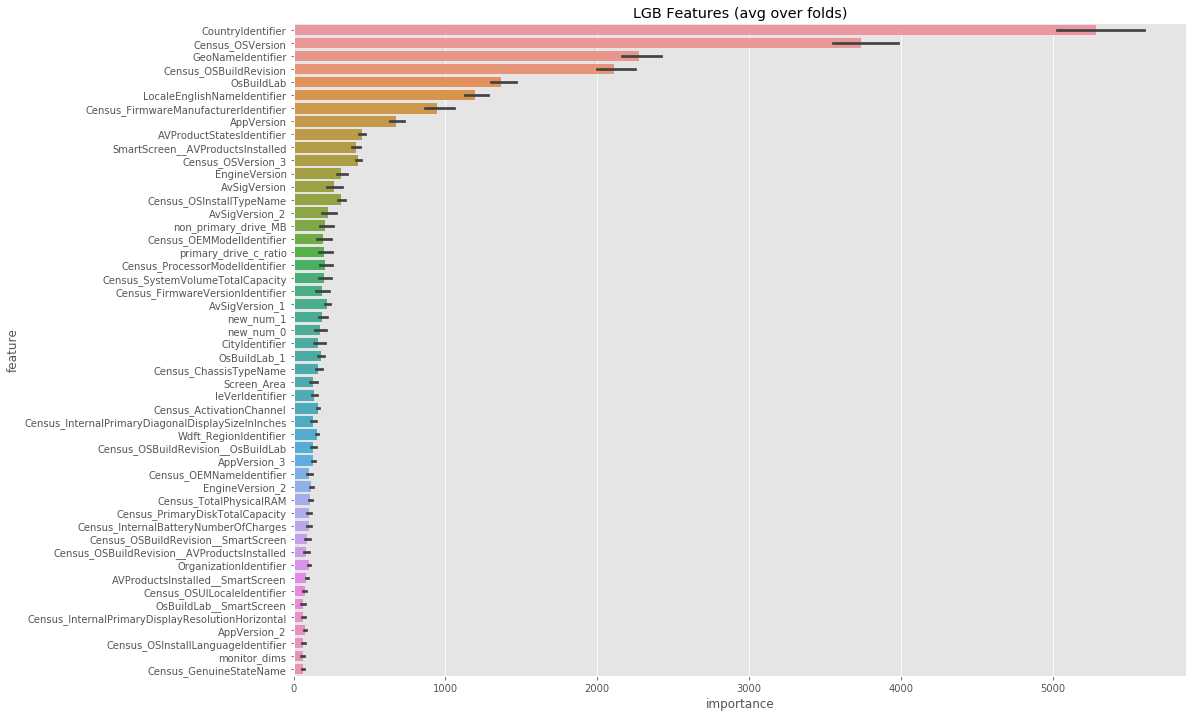

In [113]:
result_dict1 = train_model(X=train1, X_test=test, y=y1, params=params, model_type='lgb', plot_feature_importance=True, averaging='rank')

In [117]:
result_dict1['prediction']

array([5862751.2, 4246642.6, 3633129.6, ..., 2330401.4, 4815984.4,
       3321554.2])